# **Training BERT for Sentiment Analysis**

## Project Overview

The goal of this project is to develop a sentiment analysis model using BERT(Bidirectional Encoder Representations from Transformers).

In [ ]:
!pip install datasets
!pip install optuna
!pip install transformers

# **Import modules**

In [ ]:
import transformers
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
class CFG:
    MODEL = "bert-base-uncased"
    NUM_LABELS = 5
    EPOCHS = 20
    LR = 2e-5
    BATCH_SIZE = 16
    OUTPUT_DIR = "./results"
    WEIGHT_DECAY = 0.01

# **Import data**
We will be using the SST-5 dataset from Stanford NLP. The Stanford Sentiment Treebank (SST-5), also known as SST fine-grained, is a widely used dataset in the field of sentiment analysis. It was created by the Stanford Natural Language Processing Group and consists of single sentences extracted from movie reviews. The dataset provides a detailed and nuanced sentiment analysis by categorizing each sentence into one of five sentiment classes:
- Negative
- Somewhat Negative
- Neutral
- Somewhat Positive
- Positive

In [ ]:
dataset = load_dataset("SetFit/sst5")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/421 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.jsonl:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

dev.jsonl:   0%|          | 0.00/171k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/343k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8544 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1101 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2210 [00:00<?, ? examples/s]

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, dataset, tokenizer, max_length):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['text']  # Access the text data using dictionary-like access
        labels = self.dataset[idx]['label']  # Access the labels data using dictionary-like access

        encoding = self.tokenizer.encode_plus(
          text,
          add_special_tokens=True,  # Add [CLS] token at the start for classification
          max_length=self.max_length,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
          truncation=True
        )

        return {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(), # this is NOT self-attention!
          'labels': torch.tensor(labels, dtype=torch.long)
        }

tokenizer = transformers.BertTokenizer.from_pretrained(CFG.MODEL)###
training_set = SentimentDataset(dataset['train'], tokenizer, 512)
val_set = SentimentDataset(dataset['validation'], tokenizer, 512)
test_set = SentimentDataset(dataset['test'], tokenizer, 512)

train_loader = DataLoader(training_set, batch_size=CFG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=CFG.BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=CFG.BATCH_SIZE)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_df = pd.DataFrame(dataset['train'])
validation_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])

In [ ]:
train_df.head()

,text,label,label_text
0,"a stirring , funny and finally transporting re...",4,very positive
1,apparently reassembled from the cutting-room f...,1,negative
2,they presume their audience wo n't sit still f...,1,negative
3,the entire movie is filled with deja vu moments .,2,neutral
4,this is a visually stunning rumination on love...,3,positive


In [ ]:
validation_df.head()

,text,label,label_text
0,"in his first stab at the form , jacquot takes ...",2,neutral
1,one long string of cliches .,1,negative
2,if you 've ever entertained the notion of doin...,1,negative
3,k-19 exploits our substantial collective fear ...,0,very negative
4,it 's played in the most straight-faced fashio...,1,negative


In [ ]:
test_df.head()

,text,label,label_text
0,"no movement , no yuks , not much of anything .",1,negative
1,"a gob of drivel so sickly sweet , even the eag...",0,very negative
2,` how many more voyages can this limping but d...,2,neutral
3,so relentlessly wholesome it made me want to s...,2,neutral
4,"gangs of new york is an unapologetic mess , wh...",0,very negative


In [ ]:
print(f"Number of training samples: {train_df.shape}")
print(f"Number of validation samples: {validation_df.shape}")
print(f"Number of testing samples: {test_df.shape}")

Number of training samples: (8544, 3)
Number of validation samples: (1101, 3)
Number of testing samples: (2210, 3)


<Axes: title={'center': 'Testing Set Score Count'}, xlabel='label', ylabel='count'>

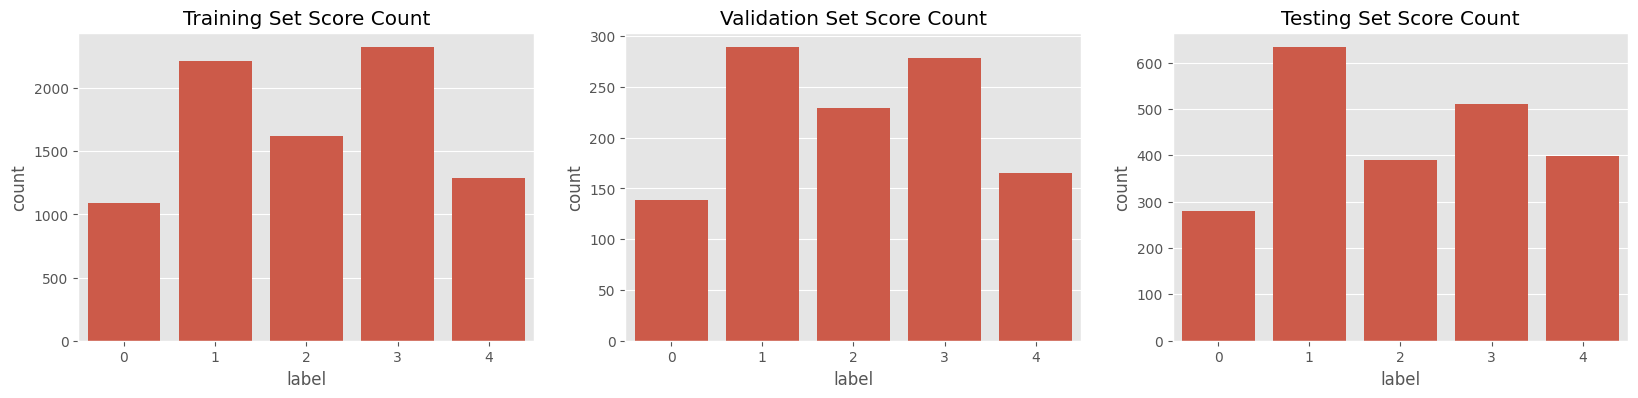

In [ ]:
plt.figure(figsize=(20, 4))
plt.style.use('ggplot')
plt.subplot(1, 3, 1)
plt.title("Training Set Score Count")
sns.countplot(train_df, x="label")

plt.subplot(1, 3, 2)
plt.title("Validation Set Score Count")
sns.countplot(validation_df, x="label")

plt.subplot(1, 3, 3)
plt.title("Testing Set Score Count")
sns.countplot(test_df, x="label")

# **Training the model**

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

cuda


In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout_prob=0.7):
        super(SentimentClassifier, self).__init__()
        self.config = transformers.BertConfig.from_pretrained(model_name, num_labels=num_labels)
        self.bert = transformers.BertModel.from_pretrained(model_name, config=self.config)
        self.pre_classifier = nn.Linear(self.config.hidden_size, self.config.hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(self.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]  # (batch_size, sequence_length, hidden_size)
        pooled_output = hidden_state[:, 0]  # take the representation of the [CLS] token (first token)
        pooled_output = self.pre_classifier(pooled_output)
        pooled_output = nn.ReLU()(pooled_output)
        pooled_output = self.dropout(pooled_output) # regularization
        logits = self.classifier(pooled_output)
        return logits

model = SentimentClassifier(CFG.MODEL, CFG.NUM_LABELS).to(device)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch_idx, batch in enumerate(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (logits.argmax(1) == labels).type(torch.float).sum().item()

        if batch_idx % 100 == 0:
            current = batch_idx * CFG.BATCH_SIZE + len(input_ids)
            print(f"Batch {batch_idx + 1}, loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    average_train_loss = train_loss / num_batches
    train_accuracy = correct / size
    print(f"Training Error: \n Accuracy: {(100*train_accuracy):>0.1f}%, Avg loss: {average_train_loss:>8f} \n")
    return average_train_loss, train_accuracy

def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            val_loss += loss_fn(logits, labels).item()
            correct += (logits.argmax(1) == labels).type(torch.float).sum().item()

    average_val_loss = val_loss / num_batches
    val_accuracy = correct / size
    print(f"Validation Error: \n Accuracy: {(100*val_accuracy):>0.1f}%, Validation loss: {average_val_loss:>8f} \n")
    return average_val_loss, val_accuracy

def evaluate_model(loader, model, loss_fn):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    correct_examples = []
    incorrect_examples = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            predictions = logits.argmax(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

            matches = predictions == labels
            for i in range(len(matches)):
                example = (input_ids[i].cpu(), labels[i].item(), predictions[i].item())
                if matches[i]:
                    correct_examples.append(example)
                else:
                    incorrect_examples.append(example)

    average_loss = total_loss / len(loader)
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    return y_true, y_pred, average_loss, accuracy, correct_examples, incorrect_examples

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
val_losses = []
train_accs = []
test_accs = []
val_accs = []
max_acc = 0
for t in range(CFG.EPOCHS):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = val_loop(val_loader, model, loss_fn)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    if max_acc < val_acc:
        print(
            f"[SAVING] Validation Accuracy Increased({(100*max_acc):>0.1f}% ---> {(100*val_acc):>0.1f}%)"
        )
        max_acc = val_acc

        # Saving State Dict
        torch.save(model.state_dict(), "saved_model.pth")
print("Done!")

Epoch 1
-------------------------------
Batch 1, loss: 1.032763  [   16/ 8544]
Batch 101, loss: 0.707082  [ 1616/ 8544]
Batch 201, loss: 0.953904  [ 3216/ 8544]
Batch 301, loss: 1.254650  [ 4816/ 8544]
Batch 401, loss: 0.898158  [ 6416/ 8544]
Batch 501, loss: 1.129728  [ 8016/ 8544]
Training Error: 
 Accuracy: 57.3%, Avg loss: 0.984029 

Validation Error: 
 Accuracy: 53.2%, Validation loss: 1.122374 

[SAVING] Validation Accuracy Increased(0.0% ---> 53.2%)
Epoch 2
-------------------------------
Batch 1, loss: 0.730308  [   16/ 8544]
Batch 101, loss: 0.825784  [ 1616/ 8544]
Batch 201, loss: 0.783177  [ 3216/ 8544]
Batch 301, loss: 0.695913  [ 4816/ 8544]
Batch 401, loss: 0.483007  [ 6416/ 8544]
Batch 501, loss: 0.851638  [ 8016/ 8544]
Training Error: 
 Accuracy: 68.9%, Avg loss: 0.766647 

Validation Error: 
 Accuracy: 50.4%, Validation loss: 1.247601 

Epoch 3
-------------------------------
Batch 1, loss: 0.644311  [   16/ 8544]
Batch 101, loss: 0.791622  [ 1616/ 8544]
Batch 201, los

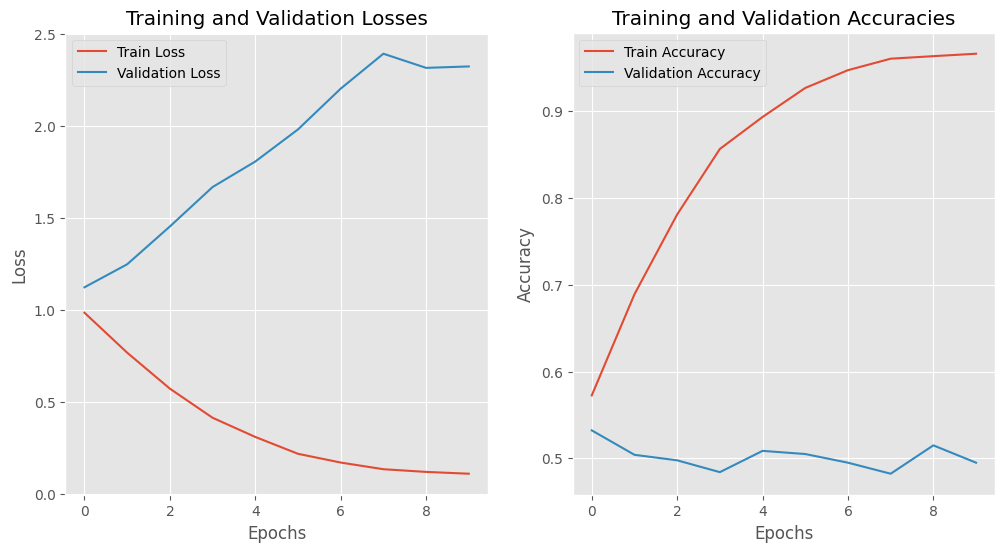

In [ ]:
plt.figure(figsize=(12, 6))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training and Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.title("Training and Validation Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
model.load_state_dict(torch.load("saved_model.pth"))
model.to(device)

<ipython-input-22-dc335700f9be>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("saved_model.pth"))


SentimentClassifier(
  (distilbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

y_true, y_pred, test_loss, test_accuracy, correct_examples, incorrect_examples = evaluate_model(test_loader, model, loss_fn)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 1.0607
Test Accuracy: 0.5457


In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.29      0.40       279
           1       0.55      0.78      0.65       633
           2       0.44      0.20      0.28       389
           3       0.49      0.70      0.58       510
           4       0.68      0.49      0.57       399

    accuracy                           0.55      2210
   macro avg       0.56      0.49      0.49      2210
weighted avg       0.55      0.55      0.52      2210



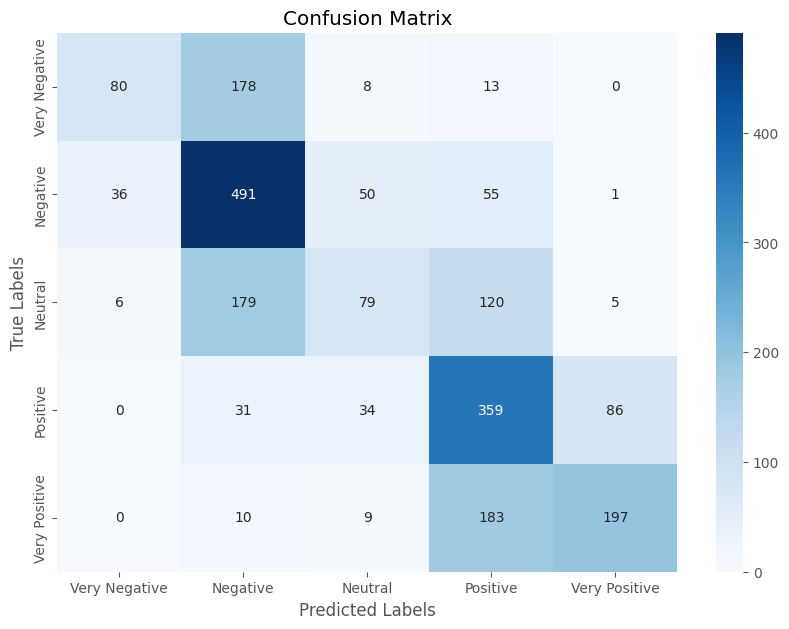

In [ ]:
class_dict = {0: 'Very Negative', 1: 'Negative', 2: 'Neutral', 3: 'Positive', 4: 'Very Positive'}

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(class_dict.values()), yticklabels=list(class_dict.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#Hyperparameter tuning

In [ ]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Update config
    CFG.LR = lr
    CFG.BATCH_SIZE = batch_size

    # Reinitialize data loaders and model
    train_loader = DataLoader(training_set, batch_size=CFG.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=CFG.BATCH_SIZE)
    model = SentimentClassifier(CFG.MODEL, CFG.NUM_LABELS).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)

    # Train and validate
    for epoch in range(CFG.EPOCHS):
        train_loop(train_loader, model, loss_fn, optimizer)
        val_loss, val_acc = val_loop(val_loader, model, loss_fn)

    # Return validation accuracy for this trial
    return val_acc

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5)

# Best hyperparameters
print("Best hyperparameters:", study.best_params)